In [42]:
from pathlib import Path
import numpy as np
import pickle as pk
from tensorflow import keras
from keras.models import load_model
from cascid.configs.config import DATA_DIR
import os
import re
import matplotlib.pyplot as plt
EXPERIMENT_DIR = DATA_DIR / 'experiments'

In [32]:
models = dict()
for d in ["final_isic", "final_pad_ufes"]:
    for mod in ['resnet34', 'resnet18']:
        for style in ['aug_hairless', 'noaug_hairless', 'noaug_raw', 'aug_raw']:
            path = EXPERIMENT_DIR / d / mod / style
            key = "{}_{}_{}".format(d , mod , style)
            # models[key] = load_model(path)
            with open(path / "history.pkl", "rb") as f:
                models[key+"_history"] = pk.load(f)

In [46]:
models_fixed = dict()
for k,v in models.items():
    models_fixed[k] = dict()
    for metric, history in v.items():
        if metric not in ["loss", "acc", "auc", "val_loss", "val_acc", "val_auc"]:
            fixed_metric = re.sub('_[0-9]', '', metric) # Remove _number from end of name
            models_fixed[k][fixed_metric] = history
        else:
            models_fixed[k][metric] = history

/tmp/ipykernel_220247/2704903475.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


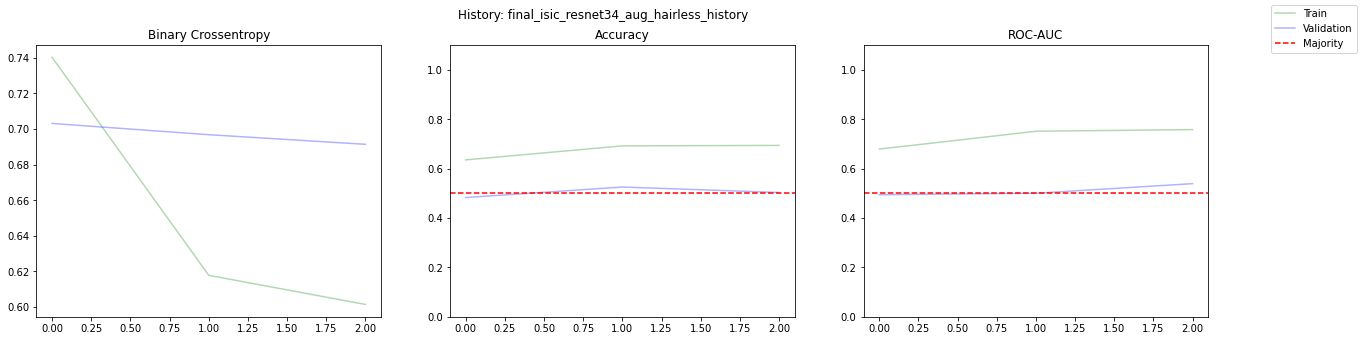

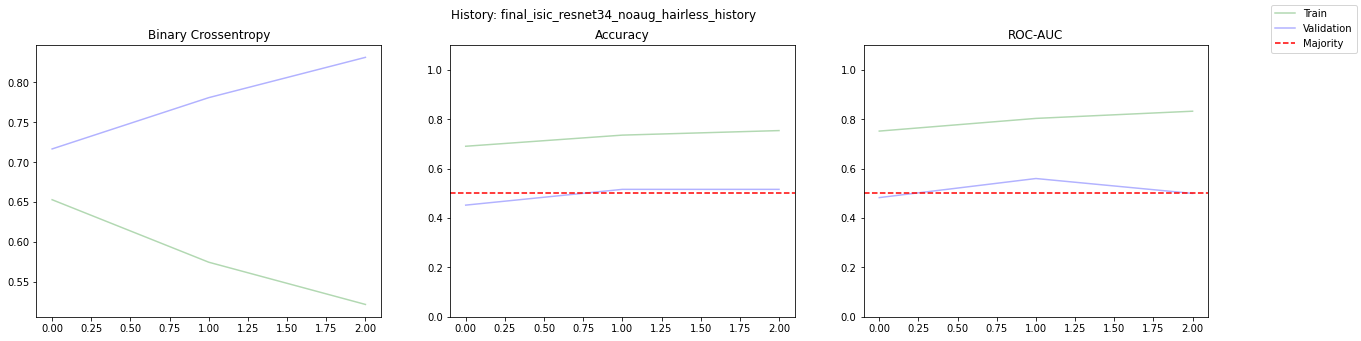

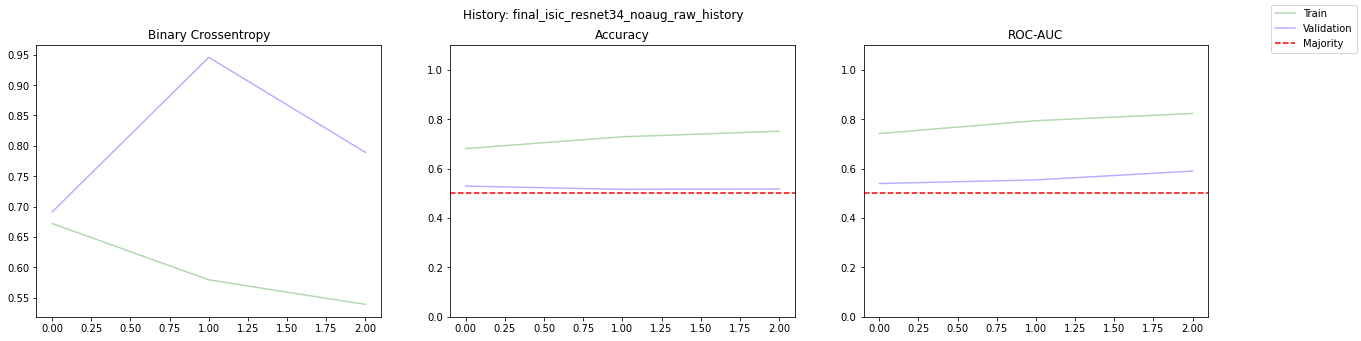

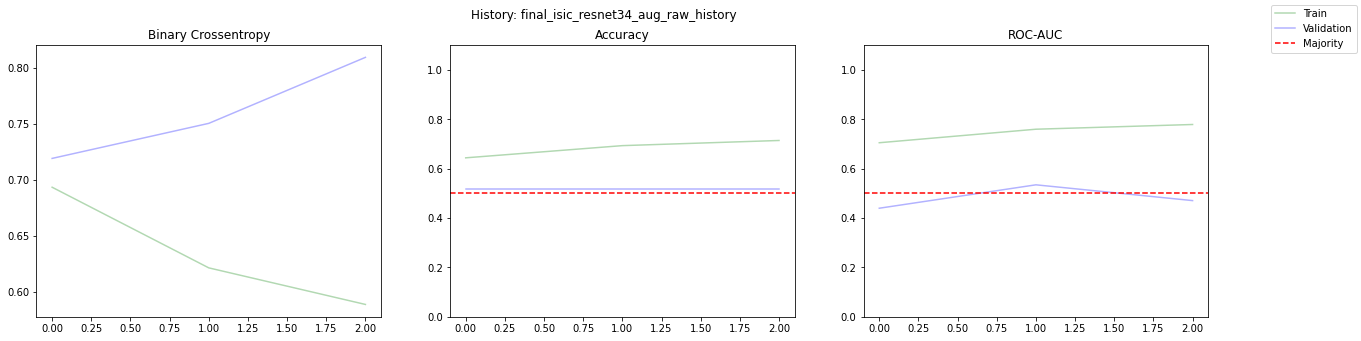

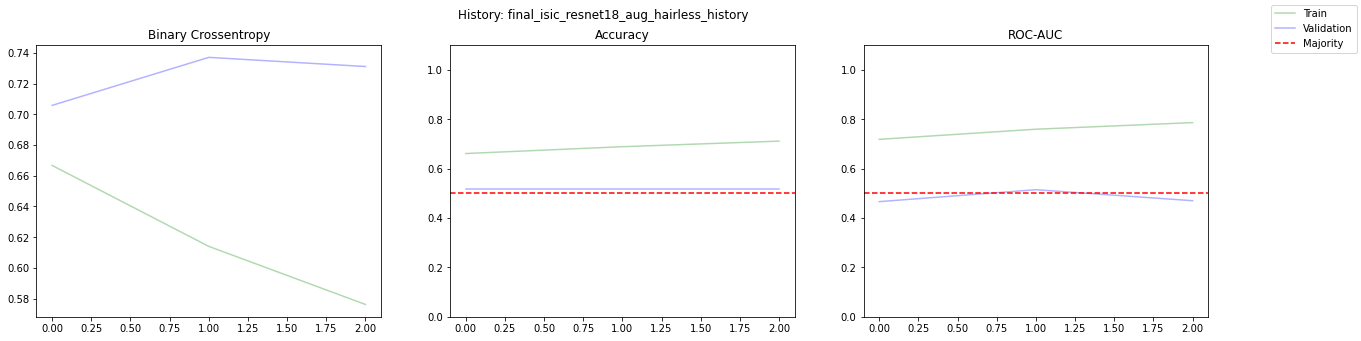

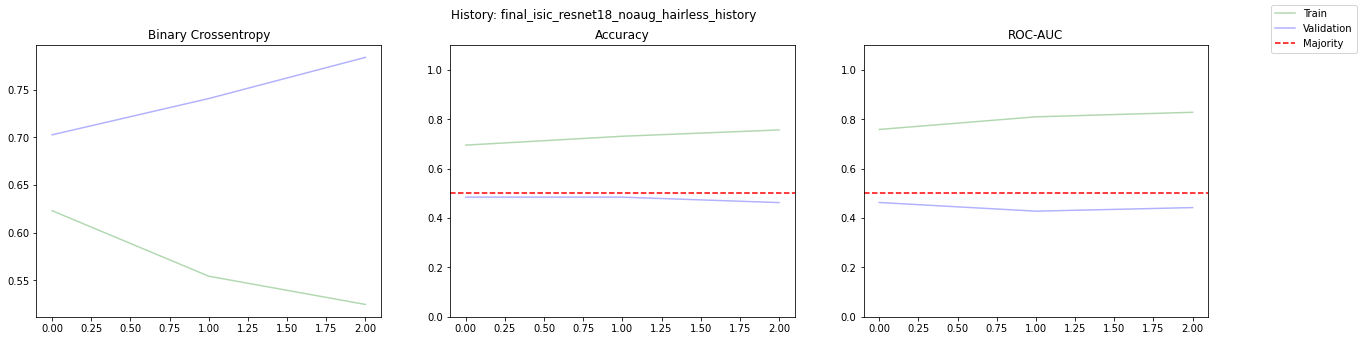

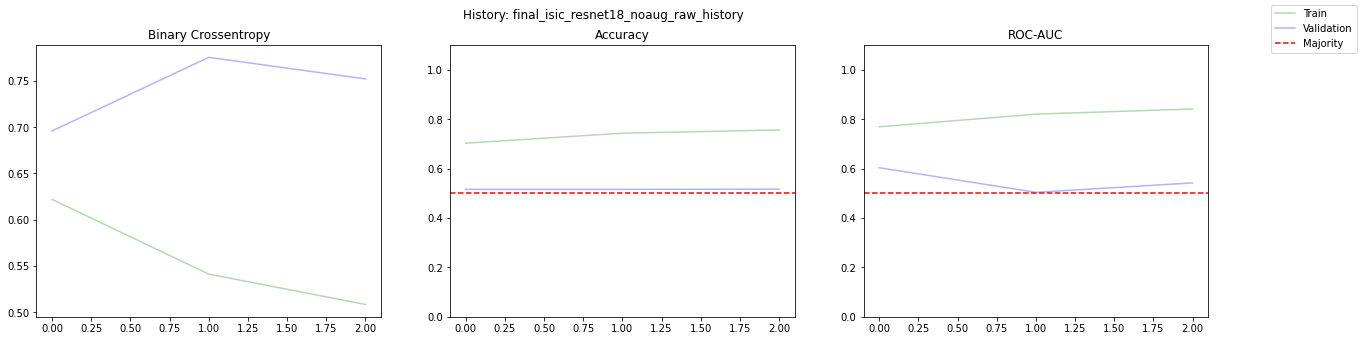

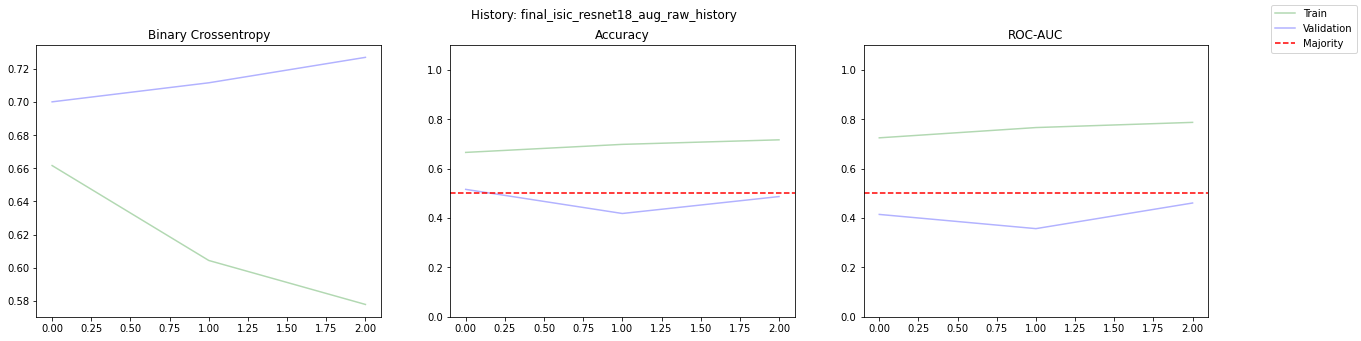

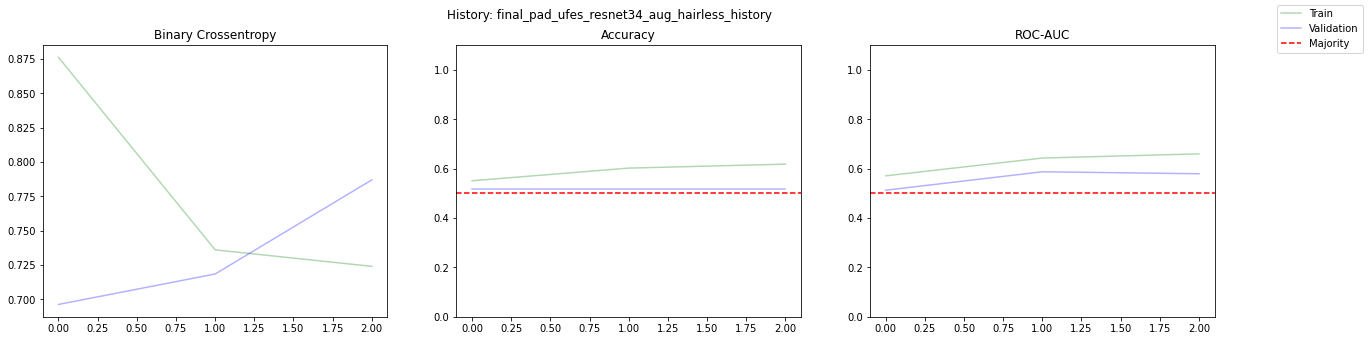

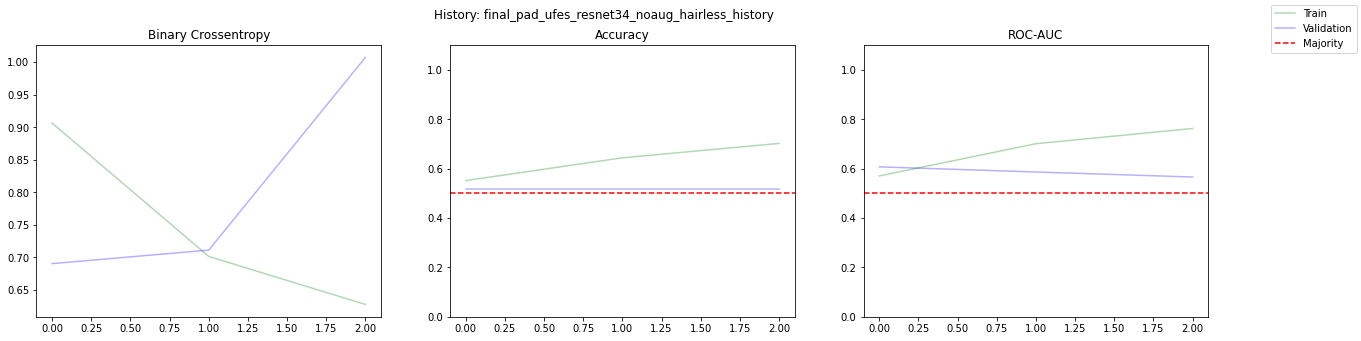

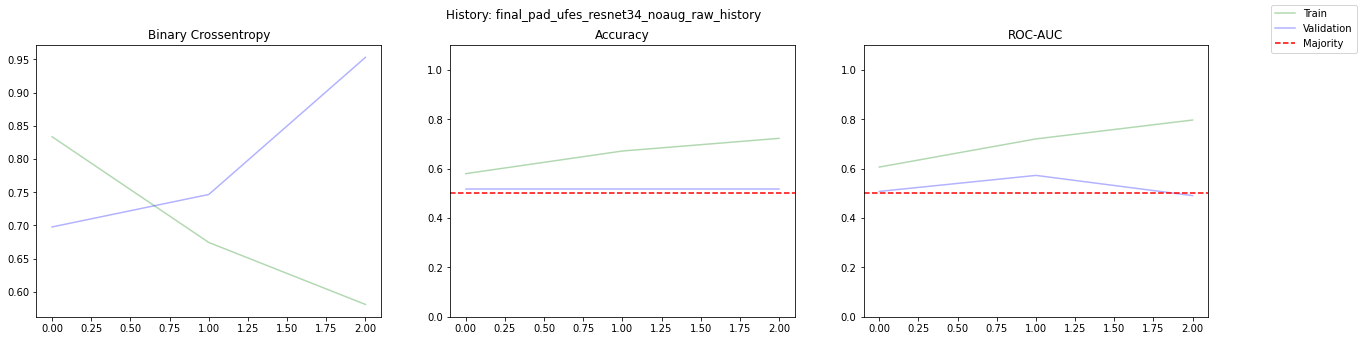

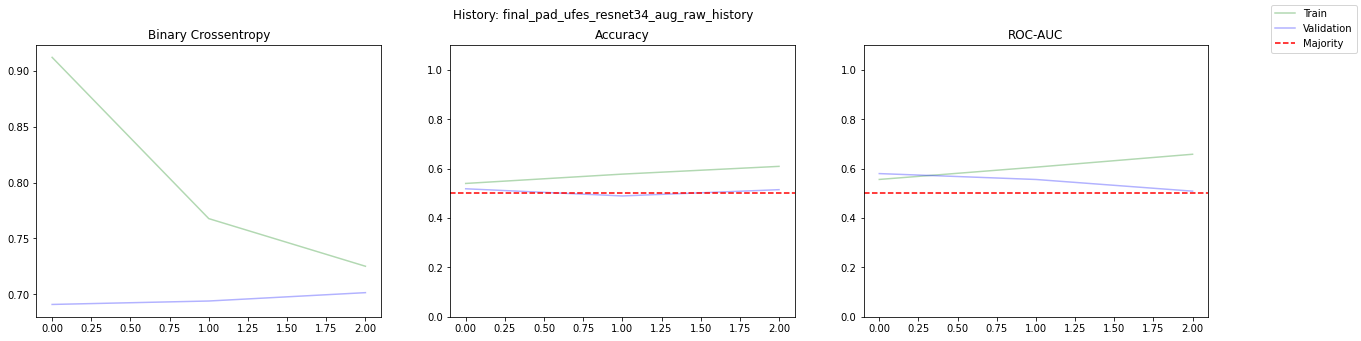

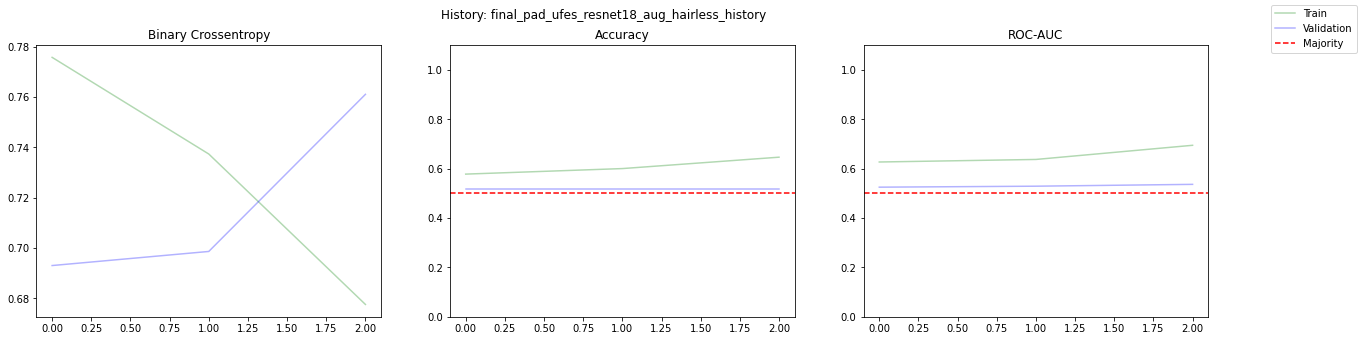

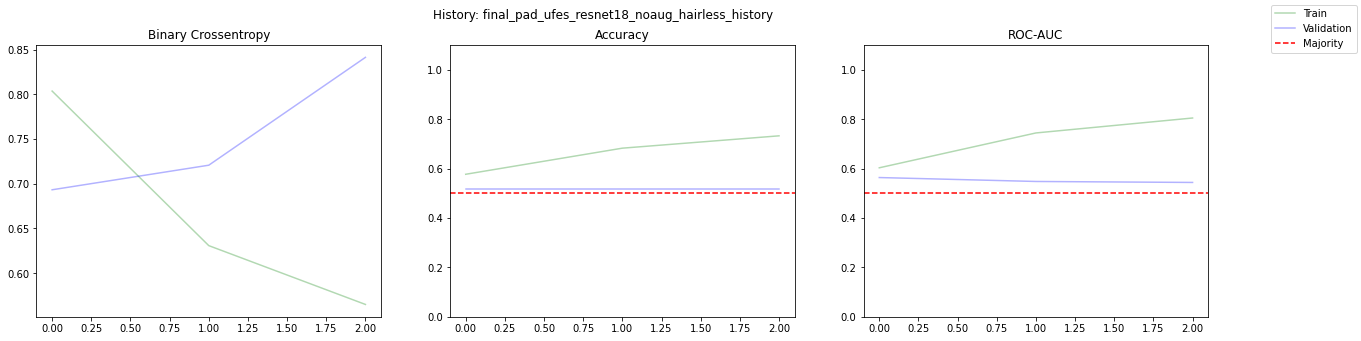

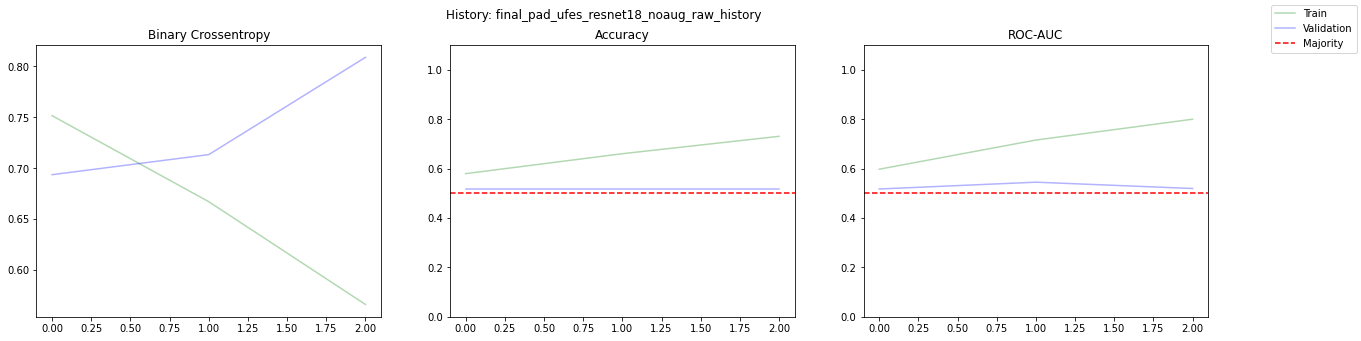

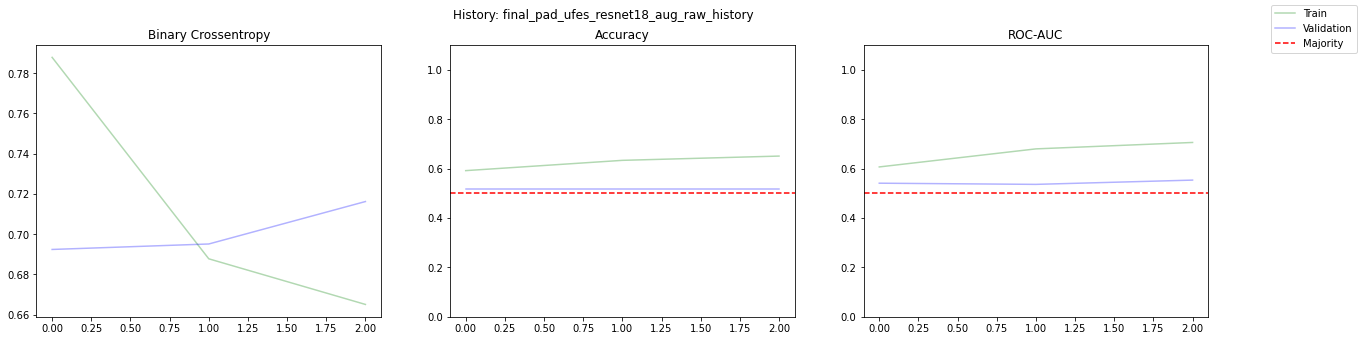

In [49]:
METRICS = ["loss", "acc", "auc"]

Names = { # Prettyfied names for titles
    "loss": "Binary Crossentropy",
    "acc": "Accuracy",
    "auc": "ROC-AUC"
}

def moving_average(a, n=25) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

DO_MOVING_AVG = False

for m_name, history in models_fixed.items():
    fig = plt.figure(figsize=(21,5))
    fig.suptitle("History: " + m_name)
    axList = []
    for i, m in enumerate(METRICS):
        axList.append(fig.add_subplot(1,3,i+1))
        try:
            train_m = history[m]
            val_m = history['val_'+m]
            x = range(len(train_m))
            axList[i].set_title(Names[m])
            if i == 0:
                axList[i].plot(x, train_m, label='Train', alpha=0.3, color='green')
                axList[i].plot(x, val_m, label='Validation', alpha=0.3, color='blue')
                if DO_MOVING_AVG:
                    axList[i].plot(x[12:-12], moving_average(train_m), label='Train Average', alpha=0.8, color='green')
                    axList[i].plot(x[12:-12], moving_average(val_m), label='Validation Average', alpha=0.8, color='blue')
            else:
                axList[i].plot(x, train_m, alpha=0.3, color='green')
                axList[i].plot(x, val_m, alpha=0.3, color='blue')
                if DO_MOVING_AVG:
                    axList[i].plot(x[12:-12], moving_average(train_m), label='Train Average', alpha=0.8, color='green')
                    axList[i].plot(x[12:-12], moving_average(val_m), label='Validation Average', alpha=0.8, color='blue')
            if m != 'loss':
                if i>1:
                    axList[i].axhline(0.5, label='Majority', c='red', ls='--')
                else:
                    axList[i].axhline(0.5, c='red', ls='--')
                axList[i].set_ylim((0, 1.1))
        except KeyError:
            continue
    fig.legend()
    fig.show();